# Task 1 : Configuration 

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm  # timm (PyTorch Image Models) library for accessing pre-trained models and utilities for image classification
import os  
from tqdm.notebook import tqdm  # tqdm for displaying progress bars in Jupyter notebooks

from helper import view_classify, show_image, show_grid, accuracy # Importing custom helper functions for visualization and calculating accuracy

In [2]:
# Configuration class to store hyperparameters and dataset information
class CFG:
    
    epochs = 20  # Number of training epochs
    lr = 0.001   # Learning rate for the optimizer
    batch_size = 16  # Batch size for training and validation

    model_name = 'densenet201'  # Name of the model to be used, sourced from timm library
    img_size = 224  # Image size for input into the model

    # Paths for dataset directories
    DATA_DIR = "./chest_xray_data"  # Root directory for the dataset
    TEST = 'test'  # Subdirectory for test data
    TRAIN = 'train'  # Subdirectory for training data
    VAL = 'val'  # Subdirectory for validation data

# Setting the device for training/testing. Uses GPU if available, else CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Print statement to confirm the device being used
print("On which device we are on : {}".format(device))


On which device we are on : cuda:1


# Task 2 : Image Transformation and Load Dataset 

In [3]:
from torchvision import transforms as T, datasets

In [4]:
# Define transformations for the training dataset
train_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size in the CFG class
    T.RandomRotation(degrees=(-20, +20)),  # Apply random rotations between -20 and +20 degrees to augment the data
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using ImageNet's mean and std
])

# Define transformations for the validation dataset
valid_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using the same mean and std
])

# Define transformations for the test dataset
test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using the same mean and std
])

In [5]:
# Constructing file paths for the training, validation, and test datasets using the CFG class
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)  # Path to the training dataset
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)    # Path to the validation dataset
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)    # Path to the test dataset

print(train_path, valid_path, test_path)

# Loading datasets using ImageFolder, which expects data to be in a certain directory structure
trainset = datasets.ImageFolder(train_path, transform=train_transform)  # Training dataset with transformations
validset = datasets.ImageFolder(valid_path, transform=valid_transform)  # Validation dataset with transformations
testset = datasets.ImageFolder(test_path, transform=test_transform)     # Test dataset with transformations

./chest_xray_data\train ./chest_xray_data\val ./chest_xray_data\test


In [6]:
# Printing the sizes of the datasets
print("Trainset Size : {}".format(len(trainset)))  # Print the number of images/samples in the training set
print("Validset Size : {}".format(len(validset)))  # Print the number of images/samples in the validation set
print("Testset Size : {}".format(len(testset)))    # Print the number of images/samples in the test set

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


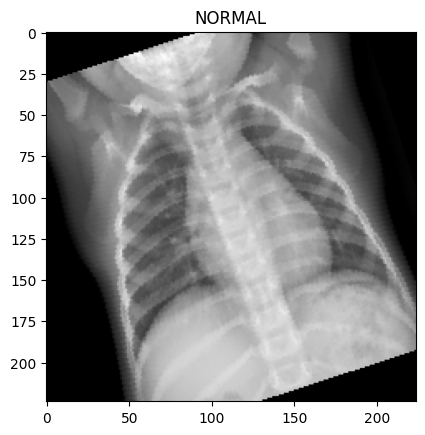

In [7]:
# Accessing a single image and its label from the training set
image, label = trainset[2]  # Retrieves the third image (index 2) and its corresponding label from the trainset

# Defining the class names for the dataset
class_names = ['NORMAL', 'PNEUMONIA']  # List of class names, corresponding to the labels in the dataset

# Displaying the image using a custom function
show_image(image, class_names[label])  # Displays the image with its class name using the show_image function

# Task 3: Load Dataset into Batches 

In [8]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid

In [9]:
# Creating data loaders for the datasets
trainloader = DataLoader(trainset, batch_size=CFG.batch_size, shuffle=True)  # DataLoader for the training dataset
validloader = DataLoader(validset, batch_size=CFG.batch_size, shuffle=True)  # DataLoader for the validation dataset
testloader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=True)    # DataLoader for the test dataset

In [10]:
# Displaying information about the training data loader
print("No. of batches in trainloader : {}".format(len(trainloader)))  # Prints the total number of batches in the trainloader
print("No. of Total examples : {}".format(len(trainloader.dataset)))  # Prints the total number of examples in the training dataset

No. of batches in trainloader : 326
No. of Total examples : 5216


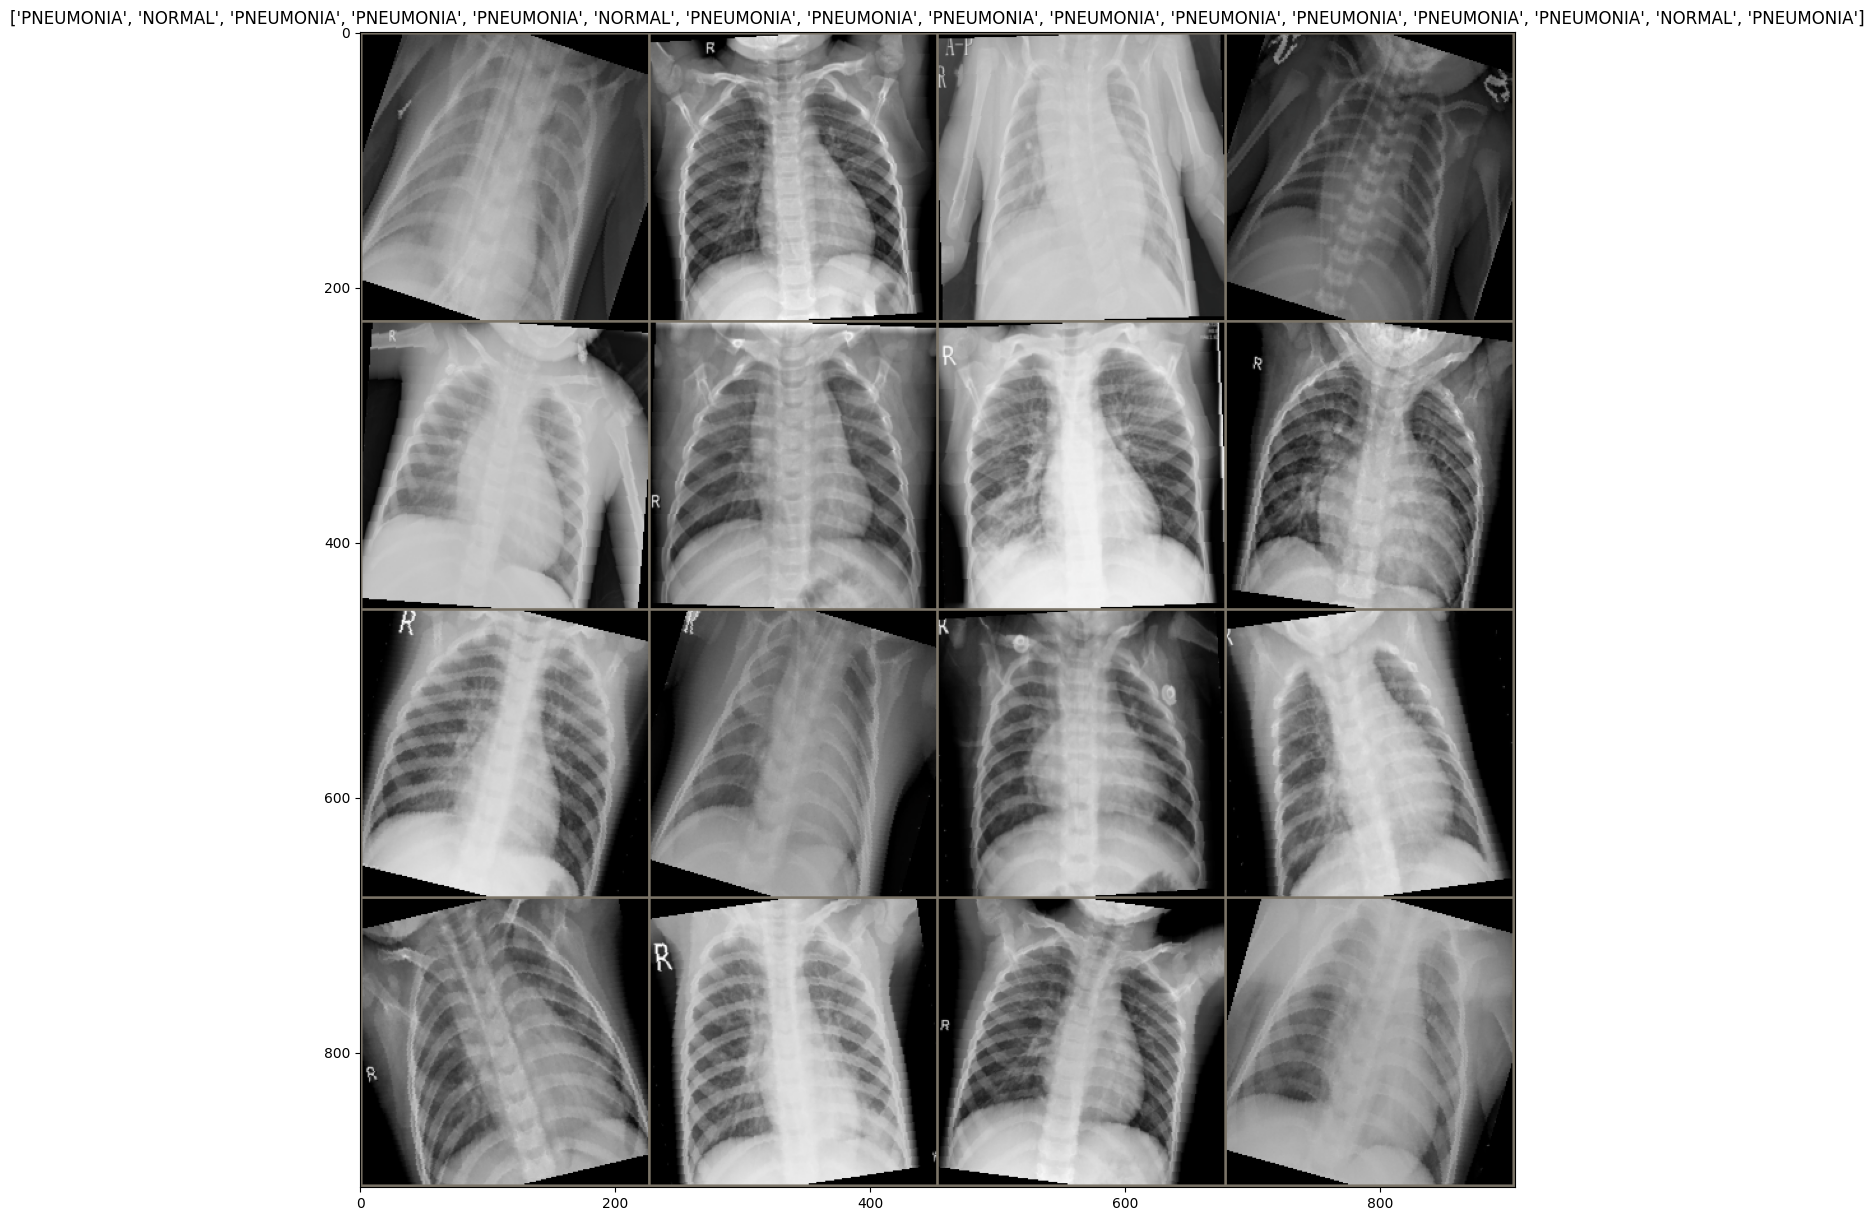

In [11]:
# Iterating through the trainloader to fetch a batch of images
dataiter = iter(trainloader)  # Create an iterator for the trainloader
images, labels = dataiter.__next__()  # Fetch the next batch of images and their corresponding labels

# Creating a grid layout of the fetched images
out = make_grid(images, nrow=4)  # Using make_grid to arrange images in a grid format, 4 images per row

# Displaying the grid of images
show_grid(out, title=[class_names[x] for x in labels])  # Using the custom show_grid function to display the images with their class names as titles

# Task 4: Fine Tuning EfficientNet Model 

In [15]:
from torch import nn 
import torch.nn.functional as F

# Creating a pre-trained model from timm (PyTorch Image Models)
model = timm.create_model(CFG.model_name, pretrained=True)  # Load a pre-trained model specified in CFG

# Freezing the parameters of the model
for param in model.parameters():
    param.requires_grad = False  # Setting requires_grad to False to freeze the parameters, so they won't be updated during training

# Customizing the classifier part of the model
model.classifier = nn.Sequential(
    nn.Linear(in_features=1920, out_features=625),  # Adjust to match DenseNet-201 output
    nn.ReLU(),  # ReLU activation function
    nn.Dropout(p=0.3),  # Dropout layer with a dropout probability of 0.3
    nn.Linear(in_features=625, out_features=256),  # Second linear layer
    nn.ReLU(),  # ReLU activation function
    nn.Linear(in_features=256, out_features=2)  # Final linear layer with 2 outputs for binary classification
)

model.to(device)  # Transferring the model to the device (GPU or CPU) for efficient computation

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

# Task 5: Build a Simple Trainer

In [16]:
# Trainer class for handling the training and validation of a neural network model for pneumonia detection
class PneumoniaTrainer():

    # Constructor for initializing the trainer with a loss function, optimizer, and scheduler
    def __init__(self, criterion=None, optimizer=None, schedular=None):
        self.criterion = criterion  # Loss function to use
        self.optimizer = optimizer  # Optimizer for adjusting model weights
        self.schedular = schedular  # Learning rate scheduler (if any)
    
    # Function to perform the training loop over all batches in the training data
    def train_batch_loop(self, model, trainloader):
        train_loss = 0.0  # Variable to accumulate loss over all batches
        train_acc = 0.0   # Variable to accumulate accuracy over all batches

        # Iterate over batches of images and labels in the training dataset
        for images, labels in tqdm(trainloader):
            
            # Move images and labels to the device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing images to the model
            logits = model(images)
            loss = self.criterion(logits, labels)  # Calculate the batch's loss

            # Backward pass and optimization
            self.optimizer.zero_grad()  # Clear the gradients of all optimized variables
            loss.backward()  # Perform backward pass to calculate gradients
            self.optimizer.step()  # Perform a single optimization step (parameter update)

            # Accumulate loss and accuracy for this batch
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        # Calculate average loss and accuracy over all batches
        return train_loss / len(trainloader), train_acc / len(trainloader)
    
    # Function to perform the validation loop over all batches in the validation data
    def valid_batch_loop(self, model, validloader):
        
        valid_loss = 0.0  # Variable to accumulate loss over all batches
        valid_acc = 0.0   # Variable to accumulate accuracy over all batches

        # Iterate over batches of images and labels in the validation dataset
        for images, labels in tqdm(validloader):

            # Move images and labels to the device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing images to the model
            logits = model(images)
            loss = self.criterion(logits, labels)  # Calculate the batch's loss

            # Accumulate loss and accuracy for this batch
            valid_loss += loss.item()
            valid_acc += accuracy(logits, labels)

        # Calculate average loss and accuracy over all batches
        return valid_loss / len(validloader), valid_acc / len(validloader)
    
    # Function to train and validate the model
    def fit(self, model, trainloader, validloader, epochs):
        
        valid_min_loss = np.Inf  # Initialize minimum validation loss to infinity for tracking improvement

        # Training loop for the specified number of epochs
        for i in range(epochs):

            model.train()  # Set the model to training mode
            # Perform training over all batches and get average loss and accuracy
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)

            model.eval()  # Set the model to evaluation mode
            # Perform validation over all batches and get average loss and accuracy
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)

            # Check if validation loss has improved, if so, save the model
            if avg_valid_loss <= valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'ColabPneumoniaModel.pt')  # Save the model's state_dict
                valid_min_loss = avg_valid_loss  # Update minimum validation loss

            # Print training and validation results for this epoch
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


# Task 6: Training Model 

In [17]:
# Using Cross-Entropy Loss as the criterion for the classification task
criterion = nn.CrossEntropyLoss()

# Setting up the optimizer - Adam optimizer with a learning rate from CFG
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

# Instantiating the PneumoniaTrainer class with the defined criterion and optimizer
trainer = PneumoniaTrainer(criterion, optimizer)

# Using the fit method of PneumoniaTrainer to start the training and validation process
trainer.fit(model, trainloader, validloader, epochs=CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.4738928973674774
Epoch : 1 Train Loss : 0.280838 Train Acc : 0.879793
Epoch : 1 Valid Loss : 0.473893 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.4738928973674774 --> 0.38270723819732666
Epoch : 2 Train Loss : 0.167266 Train Acc : 0.936350
Epoch : 2 Valid Loss : 0.382707 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.38270723819732666 --> 0.3598891496658325
Epoch : 3 Train Loss : 0.177949 Train Acc : 0.929640
Epoch : 3 Valid Loss : 0.359889 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.3598891496658325 --> 0.2778363525867462
Epoch : 4 Train Loss : 0.160903 Train Acc : 0.938842
Epoch : 4 Valid Loss : 0.277836 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.151893 Train Acc : 0.943252
Epoch : 5 Valid Loss : 0.393392 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.2778363525867462 --> 0.20509956777095795
Epoch : 6 Train Loss : 0.146944 Train Acc : 0.943443
Epoch : 6 Valid Loss : 0.205100 Valid Acc : 0.875000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.172458 Train Acc : 0.933474
Epoch : 7 Valid Loss : 0.541597 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.20509956777095795 --> 0.13660936057567596
Epoch : 8 Train Loss : 0.130218 Train Acc : 0.951304
Epoch : 8 Valid Loss : 0.136609 Valid Acc : 1.000000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.142579 Train Acc : 0.946511
Epoch : 9 Valid Loss : 0.416795 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.135796 Train Acc : 0.949386
Epoch : 10 Valid Loss : 0.142095 Valid Acc : 1.000000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.139494 Train Acc : 0.947086
Epoch : 11 Valid Loss : 0.188667 Valid Acc : 1.000000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.154601 Train Acc : 0.937692
Epoch : 12 Valid Loss : 0.309588 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.141840 Train Acc : 0.944594
Epoch : 13 Valid Loss : 0.561907 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.128232 Train Acc : 0.946127
Epoch : 14 Valid Loss : 0.295913 Valid Acc : 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.135760 Train Acc : 0.947469
Epoch : 15 Valid Loss : 0.562315 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.128993 Train Acc : 0.948236
Epoch : 16 Valid Loss : 0.346251 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.127475 Train Acc : 0.952454
Epoch : 17 Valid Loss : 0.583762 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.109615 Train Acc : 0.957055
Epoch : 18 Valid Loss : 0.612994 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.127325 Train Acc : 0.950537
Epoch : 19 Valid Loss : 0.349979 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.119949 Train Acc : 0.957630
Epoch : 20 Valid Loss : 0.253408 Valid Acc : 0.875000


# Task 7: Plot Results 

In [18]:
# Set the model to evaluation mode
model.eval()

# Evaluating the model on the test dataset
avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model, testloader)

# Printing the test loss and accuracy
print("Test Loss : {}".format(avg_test_loss))  # Print average loss on the test dataset
print("Test Acc : {}".format(avg_test_acc))    # Print average accuracy on the test dataset

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 0.3139803890998547
Test Acc : 0.8814102411270142


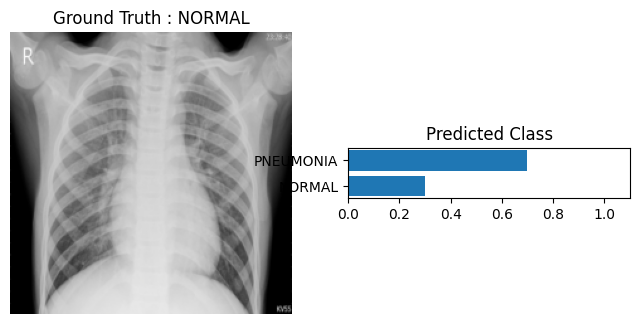

In [19]:
import torch.nn.functional as F 

# Selecting a single image and its label from the test dataset
image, label = testset[123]

# Making a prediction using the model
ps = model(image.to(device).unsqueeze(0)) 

# Applying softmax to the model's output to convert logits to probabilities
ps = F.softmax(ps, dim=1) 

# Displaying the image, the predicted probabilities, and the actual label
view_classify(image, ps, label) 

In [20]:
torch.save(model.state_dict(), 'DenseNetPneumoniaModel.pth')